# Laboratorio 2 - Redes Convolucionales - Diplomado Inteligencia Artificial UC

**IMPORTANTE: habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0.**

En este laboratorio nos interiorizaremos en cómo funciona Pytorch (https://pytorch.org/), el framework de Facebook para implementar Redes Neuronales Profundas.

Vamos a ver varias partes distintas del flujo de entrenamiento, desde cómo cargamos los datos, cómo creamos redes, cómo las entrenamos y cómo validamos su rendimiento.

## El Tensor: la unidad fundamental.

Los tensores son el elemento fundamental con que trabajarán nuestras redes profundas. Un tensor es simplemente una matriz de n-dimensiones. 

* En **imágenes**, usamos tensores de 4 dimensiones: 3 dimensiones (alto, ancho y color) más una cuarta dimensión asociada a los elementos del batch.

* Cuando trabajamos con **texto** podemos tener tensores en 3 dimensiones (dimensión de embedding, palabras y batch).

* Si trabajamos con **videos** tenemos que agregar otra dimensión para el tiempo. En fin, todos estos datos distintos al final se representan como matrices de números en 3, 4 ó 5 dimensiones distintas.

Pytorch representa los tensores via la clase torch.Tensor. Todas las redes neuronales que hagamos requieren tensores para poder trabajar. Nuestros datasets no servirán de nada si no podemos transformarlos en tensores que podamos ocupar con nuestras redes. Si han trabajado con *ndarray* de Numpy la forma de ocuparlos es muy similar. Veamos un tensor de ejemplo de 3 dimensiones: ancho, alto y batch. 

In [1]:
import torch

batch_dim = 5
alto = 2
ancho = 3
tensor_ejemplo = torch.randn((batch_dim, ancho, alto)).float() # Tensor aleatorio
print("El tensor es: {}\n".format(tensor_ejemplo))
print("La forma del tensor es: {}".format(tensor_ejemplo.shape))
print("El tipo del tensor es: {}".format(type(tensor_ejemplo)))

El tensor es: tensor([[[ 0.0628, -0.9507],
         [-1.2270,  0.4503],
         [ 0.3438,  1.0220]],

        [[-0.0261,  0.6921],
         [ 0.0907,  0.8105],
         [ 0.6341, -1.4089]],

        [[ 0.2022,  0.9402],
         [-2.2096,  1.0981],
         [ 1.0203, -0.7037]],

        [[-0.1311,  0.8031],
         [-0.6545, -0.3806],
         [-0.9115, -0.3599]],

        [[ 0.4298,  0.6213],
         [-0.4998,  1.6038],
         [-1.3326,  1.4618]]])

La forma del tensor es: torch.Size([5, 3, 2])
El tipo del tensor es: <class 'torch.Tensor'>


Crear un tensor desde un arreglo de Python es sencillo:

In [2]:
arreglo = [[1, 2, 3], [4, 5, 6]]
tensor_desde_arreglo = torch.tensor(arreglo)
print(tensor_desde_arreglo, tensor_desde_arreglo.shape)

tensor([[1, 2, 3],
        [4, 5, 6]]) torch.Size([2, 3])


Uno trabaja los tensores de la misma manera que cualquier otra variable numérica en Python. Se pueden, sumar y restar sin problema. La multiplicación por escalares no supone problema y la multiplicación de tensores también está soportada.



In [3]:
tensor_1 = torch.randn((1,2,3))
tensor_2 = torch.randn((1,2,3))

tensor_3 = tensor_1 + tensor_2

print(tensor_1)
print(tensor_2)
print(tensor_3)

tensor([[[ 0.4805, -1.0274, -0.4928],
         [-0.2328, -0.5994, -0.4366]]])
tensor([[[-0.3093,  0.3467,  1.8701],
         [-0.1841, -0.7706, -0.3375]]])
tensor([[[ 0.1712, -0.6807,  1.3773],
         [-0.4169, -1.3700, -0.7742]]])


Podemos indexarlos:

In [4]:
tensor_indexado = tensor_1[:,:,:2]
print(tensor_indexado, tensor_indexado.shape)

tensor([[[ 0.4805, -1.0274],
         [-0.2328, -0.5994]]]) torch.Size([1, 2, 2])


#### Sobre la dimensión batch

La dimensión de batch es importante pues es la que nos permite poder entrenar de forma paralela en nuestras GPUs. El estándar de Pytorch es que ésta es la primera dimensión de nuestros tensores siempre. Aunque solo evaluar un elemento en nuestra red, este debe tener una dimensión de batch en su primer lugar o sino no funcionará. También es necesario mencionar que Pytorch espera siempre que la dimensión del canal vaya antes que las dimensiones de ancho y alto en imágenes.

### Sobre el dispositivo asociado

Los tensores son procesados por la CPU o por una GPU. Como quizás hemos escuchado antes, sabemos que parte de la explosión de Deep Learning viene por la disponibilidad de GPUs cada vez más poderosas. Para poder trabajar en GPU un tensor tenemos que hacer lo siguiente:

In [5]:
tensor_nuevo = torch.randn((1,2,3))     # Por defecto el tensor está en CPU
tensor_nuevo_gpu = tensor_nuevo.cuda()  # Creé una copia de tensor_nuevo en GPU!
otra_forma = tensor_nuevo.to('cuda')    # Creé otra copia de tensor_nuevo en GPU!

## Definición del Modelo
Como vimos en el laboratorio pasado, definir un modelo de aprendizaje profundo consiste en definir una nueva clase que herede de torch.nn.Module.

Esta clase debe implementar dos métodos para funcionar como un modelo válido en Pytorch:

* Método \_\_init\_\_(self): el constructor de la clase. Aquí es donde usualmente definiremos todos los elementos arquitéctonicos de nuestra red. Aquí definiremos que capas tendrá, qué funciones de activación, funciones de pooling, etc.

* Método forward(self, input): define las conexiones entre capas del modelo, o cómo debe fluir la información que entra en él. Debe retornar un tensor.

### Elementos arquitectónicos

Todos estos elementos están definidos en el paquete torch.nn (de Neural Networks). Todos derivan de la clase torch.nn.Module.

* **Linear:** capa lineal. Toma como parámetros las cantidades de neuronas de entrada y de salida.
* **Conv1d, Conv2d, Conv3d**: capas convolucionales de 1, 2 y 3 dimensiones respectivamente. Definidas por el tamaño del kernel que ocupan, el *stride*, filtros de entrada y de salida.
* **ReLU**: función de activación. No tiene parámetros.
* **Sigmoid**: función de activación. No tiene parámetros.
* **Softmax**: capa que transforma el output en una distribución de probabilidad. Parámetro es sobre la o las dimensiones que se aplica.
* **MaxPool1d, MaxPool2d, MaxPool3d**: Funciones de pooling en 1,2 y 3 dimensiones respectivamente.
* **Dropout**: capa que deja en 0 neuronas con probabilidad $p$. Parámetro: $p$.
* **BatchNorm2d**: capa que normaliza el input de acuerdo a una media y varianza aprendidas. 
* **Sequential**: es un agrupador de Módulos. Se encarga de que la información fluya de forma secuencial entre los módulos que contiene.

In [6]:
import torch
from torch.nn import Linear, ReLU, Sigmoid, Sequential, Softmax, BatchNorm1d, BatchNorm2d, Dropout

tensor_prueba = torch.randn((3, 5))

print(tensor_prueba, tensor_prueba.shape)

# Capa Lineal que va de 5 dimensiones a 8
capa_lineal = Linear(5, 8)
tensor_nuevo = capa_lineal(tensor_prueba)
print("Tensor después de Capa Lineal:")
print(tensor_nuevo, tensor_nuevo.shape)

tensor([[-1.2913, -1.6422, -0.1152,  0.2673, -0.4242],
        [ 0.5121, -0.8636, -1.2194, -0.3850,  0.7996],
        [-0.9025, -0.5047,  1.5817, -0.0426, -0.2112]]) torch.Size([3, 5])
Tensor después de Capa Lineal:
tensor([[-1.4172,  0.2860, -0.4144,  0.4446, -1.1229, -0.3033,  0.2553, -0.2322],
        [-0.6428,  0.0117, -0.0732,  0.5970,  0.4639, -0.0060, -0.2565, -0.4994],
        [-0.6700,  0.3882, -0.2621,  0.1579, -1.1278, -0.8477,  0.7021,  0.3488]],
       grad_fn=<AddmmBackward>) torch.Size([3, 8])


In [7]:
# Funciones de Activación
# ReLU
relu = ReLU()
print("Antes de ReLU: ")
print(tensor_prueba)
print("Después de ReLU: ")
print(relu(tensor_prueba))

Antes de ReLU: 
tensor([[-1.2913, -1.6422, -0.1152,  0.2673, -0.4242],
        [ 0.5121, -0.8636, -1.2194, -0.3850,  0.7996],
        [-0.9025, -0.5047,  1.5817, -0.0426, -0.2112]])
Después de ReLU: 
tensor([[0.0000, 0.0000, 0.0000, 0.2673, 0.0000],
        [0.5121, 0.0000, 0.0000, 0.0000, 0.7996],
        [0.0000, 0.0000, 1.5817, 0.0000, 0.0000]])


In [8]:
# Sigmoid
s = Sigmoid()
print("Antes de Sigmoid: ")
print(tensor_prueba)
print("Después de Sigmoid: ")
print(s(tensor_prueba))

Antes de Sigmoid: 
tensor([[-1.2913, -1.6422, -0.1152,  0.2673, -0.4242],
        [ 0.5121, -0.8636, -1.2194, -0.3850,  0.7996],
        [-0.9025, -0.5047,  1.5817, -0.0426, -0.2112]])
Después de Sigmoid: 
tensor([[0.2156, 0.1622, 0.4712, 0.5664, 0.3955],
        [0.6253, 0.2966, 0.2280, 0.4049, 0.6899],
        [0.2885, 0.3764, 0.8294, 0.4894, 0.4474]])


In [9]:
# Softmax
soft = Softmax(dim=1)
print("Antes de Softmax: ")
print(tensor_prueba)
print("Después de Softmax: ")
soft_tensor = soft(tensor_prueba)
print(soft_tensor)
print(soft_tensor.sum(dim=1))

Antes de Softmax: 
tensor([[-1.2913, -1.6422, -0.1152,  0.2673, -0.4242],
        [ 0.5121, -0.8636, -1.2194, -0.3850,  0.7996],
        [-0.9025, -0.5047,  1.5817, -0.0426, -0.2112]])
Después de Softmax: 
tensor([[0.0828, 0.0583, 0.2684, 0.3934, 0.1970],
        [0.3154, 0.0797, 0.0558, 0.1286, 0.4205],
        [0.0531, 0.0790, 0.6365, 0.1254, 0.1060]])
tensor([1.0000, 1.0000, 1.0000])


In [10]:
# Sequential
# Unamos pasos
seq = Sequential(capa_lineal, relu, soft)
tensor_final = seq(tensor_prueba)
print("Aplicando Sequential: ")
print(tensor_final, tensor_final.shape)

Aplicando Sequential: 
tensor([[0.1089, 0.1450, 0.1089, 0.1699, 0.1089, 0.1089, 0.1406, 0.1089],
        [0.1062, 0.1074, 0.1062, 0.1929, 0.1688, 0.1062, 0.1062, 0.1062],
        [0.0992, 0.1463, 0.0992, 0.1162, 0.0992, 0.0992, 0.2002, 0.1406]],
       grad_fn=<SoftmaxBackward>) torch.Size([3, 8])


In [11]:
# Dropout
drop = Dropout(p=0.15) # con probabilidad de dejar en 0 de 0.15.
tensor_dropout = drop(tensor_prueba)
print(tensor_dropout)

tensor([[-1.5192, -1.9319, -0.1355,  0.3144, -0.0000],
        [ 0.0000, -1.0160, -1.4346, -0.0000,  0.9407],
        [-1.0618, -0.5938,  1.8608, -0.0501, -0.2485]])


In [12]:
# Batch Normalization 1d
tensor_lineal = 20*torch.randn((3, 5))  # Una imagen con varianza alta
bn = BatchNorm1d(5, momentum=None)                             # 3 es el número de canales


print("La media de los vectores originales por dimensión es: {}".format(tensor_lineal.mean(dim=[0])))   
print("La varianza de los vectores originales por dimensión es: {}".format(tensor_lineal.var(dim=[0], unbiased=False)))
print("Las medias por dimensión de BN inicialmente son: {}".format(bn.running_mean))
print("Las varianzas por dimensión de BN inicialmente son: {}".format(bn.running_var))

tensor_bn = bn(tensor_lineal)

print("La media por dimensión del resultado es: {}".format(tensor_bn.mean(dim=[0])))   
print("La varianza por dimensión del resultado es: {}".format(tensor_bn.var(dim=[0], unbiased=False)))
print("Las medias por dimensión de BN ahora son: {}".format(bn.running_mean))
print("Las varianzas por dimensión de BN ahora son: {}".format(bn.running_var))  

for n, p in bn.named_parameters():
    print(n,p)

La media de los vectores originales por dimensión es: tensor([ 7.0683,  8.7154,  8.1161, 22.8584, -4.9177])
La varianza de los vectores originales por dimensión es: tensor([436.5844, 427.5392, 706.6785, 271.8681, 539.7061])
Las medias por dimensión de BN inicialmente son: tensor([0., 0., 0., 0., 0.])
Las varianzas por dimensión de BN inicialmente son: tensor([1., 1., 1., 1., 1.])
La media por dimensión del resultado es: tensor([-9.9341e-09,  0.0000e+00,  0.0000e+00, -3.9736e-08,  0.0000e+00],
       grad_fn=<MeanBackward1>)
La varianza por dimensión del resultado es: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<VarBackward1>)
Las medias por dimensión de BN ahora son: tensor([ 7.0683,  8.7154,  8.1161, 22.8584, -4.9177])
Las varianzas por dimensión de BN ahora son: tensor([ 654.8766,  641.3088, 1060.0178,  407.8022,  809.5591])
weight Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
bias Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=

In [13]:
# Batch Normalization 2d
tensor_imagenes = 20*torch.randn((3, 3, 2, 2))  # Una imagen con varianza alta
bn = BatchNorm2d(3, momentum = None, eps=0.0)                             # 3 es el número de canales


print("La media de las imágenes originales por canal es: {}".format(tensor_imagenes.mean(dim=[0,2,3])))   
print("La varianza de las imágenes originales por canal es: {}".format(tensor_imagenes.var(dim=[0,2,3], unbiased=False)))
print("Las medias por canal de BN inicialmente son: {}".format(bn.running_mean))
print("Las varianzas por canal de BN inicialmente son: {}".format(bn.running_var))

tensor_bn = bn(tensor_imagenes)

print("La media por canal es: {}".format(tensor_bn.mean(dim=[0,2,3])))   
print("La varianza por canal es: {}".format(tensor_bn.var(dim=[0,2,3], unbiased=False)))
print("Las medias por canal de BN ahora son: {}".format(bn.running_mean))
print("Las varianzas por canal de BN ahora son: {}".format(bn.running_var))

for n, p in bn.named_parameters():
    print(n,p)

La media de las imágenes originales por canal es: tensor([ 7.9804,  2.7427, -1.3530])
La varianza de las imágenes originales por canal es: tensor([446.7048, 501.9675, 587.4157])
Las medias por canal de BN inicialmente son: tensor([0., 0., 0.])
Las varianzas por canal de BN inicialmente son: tensor([1., 1., 1.])
La media por canal es: tensor([-2.2352e-08,  4.9671e-09,  1.9868e-08], grad_fn=<MeanBackward1>)
La varianza por canal es: tensor([1., 1., 1.], grad_fn=<VarBackward1>)
Las medias por canal de BN ahora son: tensor([ 7.9804,  2.7427, -1.3530])
Las varianzas por canal de BN ahora son: tensor([487.3143, 547.6009, 640.8171])
weight Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
bias Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


### Revisitando AlexNet

In [14]:
import torch
import torch.nn as nn           # Esto es PyTorch y su módulo de Redes Neuronales

class MiAlexNet(nn.Module):               # Esta clase representa nuestro modelo

    def __init__(self):   # Constructor, aquí armamos las piezas de nuestra red
        super(MiAlexNet, self).__init__()
        # Bloques Convolucionales
        # Recordemos que los Bloques Convolucionales van a estar hechos de 3
        # elementos: Convolución, Pooling y Activación.
        # En este caso usaremos Convoluciones 2d, Max Pooling y ReLU


        # Input = 3x 224 x 224 Output = 96 x 55 x 55 --> Max Pool = 96 x 27 x 27
        self.conv1 = nn.Sequential(
            nn.Conv2d(                           # Todo esto define a la Convolución
                      in_channels=3,             # Filtros/Canales de Entrada (RGB)
                      out_channels=96,           # Filtros/Canales de Salida
                      kernel_size=(11,11),       # Tamaño de la Convolución
                      stride=(4,4),              # Stride
                      padding=2),                # Cuántos pixeles de padding
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)), # Max Pooling
            nn.ReLU()                            # Activación                            
        )

        # Input = 96 x 27 x 27 Output = 256 x 27 x 27 --> Max Pool = 256 x 13 x 13
        self.conv2 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=96,            
                      out_channels=256,         
                      kernel_size=(5,5),         
                      stride=(1,1),              
                      padding=2),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                                 
        )
        # Input = 256 x 13 x 13 Output = 384 x 13 x 13
        self.conv3 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=256,          
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                                     
        )
        # Input = 384 x 13 x 13 Output = 384 x 13 x 13
        self.conv4 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=384,           
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                            
        )
        # Input = 384 x 13 x 13 Output = 256 x 13 x 13 --> MaxPool = 256 x 6 x 6
        self.conv5 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=384,           
                      out_channels=256,       
                      kernel_size=(3,3),         
                      stride=(1,1),          
                      padding=1),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                               
        )
        ##
        self.flat = nn.Flatten()    # Capa aplanamiento para poder vincular
                                    # resultado convolucional con capas
                                    # lineales.

        # Bloques Fully Connected/MLP
        # Input = 256 x 6 x 6 = 9216 Output = 4096
        self.fc6 = nn.Sequential( #nn.Dropout(),
                                  nn.Linear(9216, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 4096
        self.fc7 = nn.Sequential(  #nn.Dropout(),
                                  nn.Linear(4096, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 1000
        self.fc8 = nn.Sequential(
                                  nn.Linear(4096, 102)
                                  )

    def forward(self, x):        # Aquí armamos cómo se conectan las piezas
                                 # Esta red es sencilla pues solo tenemos
                                 # que conectar las piezas una detrás de la
                                 # otra. No todas las redes son así.                      
        x = self.conv1(x)
        x = self.conv2(x)   
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flat(x)
        x = self.fc6(x) 
        x = self.fc7(x)
        x = self.fc8(x)

        return x

## Manejo de Datos

En un problema normal de Machine Learning, usualmente la gestión de datos no era muy importante dado que los datasets en general son pequeños. Sin embargo, dados los volúmenes de datos que requieren los modelos de aprendizaje profundo, se vuelve difícil mantener los datos en memoria. Por esto, se requiere consumirlos de manera parcelada para poder ocuparlos con las restricciones de hardware que tenemos.

Pytorch resuelve el problema mediante dos abstracciones: las clases *Dataset* y *DataLoader*. 

* La clase *Dataset* trabaja como una interfaz sencilla para acceder nuestros datos físicos.
* La clase *DataLoader* se encarga de agrupar los elementos de la clase *Dataset* en *batches* para pasarle a nuestro modelo.

Usualmente, el mayor trabajo reside en definir una clase Dataset apropiada para nuestro conjunto de datos. Por suerte, si queremos trabajar con ciertos conjuntos de datos estándar, Pytorch ya tiene definido estos datasets por nosotros.

Si no, lo único que tenemos que hacer es definir una clase que herede de torch.utils.data.Dataset y que implemente dos métodos:

* \_\_len(self)\_\_: método que devuelva el tamaño total del dataset.
* \_\_getitem\_\_(self, index): método que entregue un elemento particular del dataset dado un índice (index).

### Usar Datasets predefinidos

In [15]:
from torchvision.datasets import MNIST, CIFAR10

mnist_train = MNIST(root=".", train=True, download=True)
cifar = CIFAR10(root=".", train=True, download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./cifar-10-python.tar.gz to .


Veamos un ejemplo del dataset.

In [16]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FC93406F828>, 5)

Vemos que contiene dos elementos: el primero es una imagen en formato PIL y el segundo es la clase asociada a esa imagen (nuestro target o ground truth). La imagen se ve así:

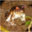

In [17]:
from IPython.display import display     # Esto no es Pytorch, es solo una librería
                                        # para desplegar imágenes en Colab.
display(mnist_train[0][0])
display(cifar[0][0])

Sin embargo, una imagen en formato PIL no es un tensor de Pytorch. Tenemos que hacer algo para transformarla! Por suerte para nosotros, Pytorch nos ofrece transformaciones estándar para imágenes, en particular, una para transformar imágenes PIL a tensores. Veamos cómo:

In [18]:
from torchvision.transforms import ToTensor
mnist_train = MNIST(root=".", train=True, download=True, transform=ToTensor())

In [19]:
mnist_train[9]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Ahora nuestro Dataset automáticamente transforma las imágenes PIL a tensores de Pytorch!

### Crear un Dataset de ejemplo

Vamos a crear un Dataset para el conjunto de datos Flowers que vimos el laboratorio pasado.

In [20]:
!wget https://www.dropbox.com/s/q53g4cmpnvzhnhi/flowers.tar.gz -q --show-progress
!tar -xzf flowers.tar.gz

flowers.tar.gz      100%[===================>] 328.99M  73.0MB/s    in 4.6s    


In [21]:
from os import listdir
from os.path import join
from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Resize
class Flowers(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imagenes = []       # Vincula el indice con un nombre de archivo
        self.imgs_to_class = []  # Vincula el indice con una clase
        self.imagenes, self.imgs_to_class = self.armar_indices(root)
    
    def armar_indices(self, root):
        n_classes = len(listdir(root)) # El número de carpetas es la cantidad de clases
        contador = 0
        lista_imagenes = []
        imgs_to_class = []
        for clase in listdir(root):
            directorio = join(root, clase)
            for archivo in listdir(directorio):
                lista_imagenes.append(archivo)
                contador+=1
                imgs_to_class.append(int(clase))

        return lista_imagenes, imgs_to_class

    def obtener_imagen(self, archivo):

        im = Image.open(archivo)
        return im

    def __getitem__(self, idx):

        nombre_archivo = self.imagenes[idx]
        clase = self.imgs_to_class[idx]
        ruta_img = join(self.root, str(clase))
        ruta_img = join(ruta_img, nombre_archivo)
        img = self.obtener_imagen(ruta_img)

        if self.transform is not None:
            img = self.transform(img)
        return img, clase
    
    def __len__(self):
        return len(self.imagenes)

In [22]:
transforms = Compose([Resize((224,224)), ToTensor()])
f = Flowers('flowers_dataset/train', transform=transforms)
display(f[0])

(tensor([[[0.0157, 0.0078, 0.0235,  ..., 0.1961, 0.2000, 0.1647],
          [0.0000, 0.0000, 0.0157,  ..., 0.0588, 0.0431, 0.0471],
          [0.0157, 0.0078, 0.0353,  ..., 0.1294, 0.1137, 0.1255],
          ...,
          [0.2078, 0.1804, 0.1569,  ..., 0.0627, 0.0784, 0.0902],
          [0.2157, 0.1922, 0.1059,  ..., 0.0431, 0.0706, 0.0784],
          [0.2078, 0.1882, 0.0627,  ..., 0.0353, 0.0431, 0.0275]],
 
         [[0.1569, 0.1412, 0.1529,  ..., 0.4588, 0.4510, 0.4196],
          [0.1098, 0.1059, 0.1490,  ..., 0.2706, 0.2510, 0.2667],
          [0.1216, 0.1294, 0.1804,  ..., 0.3373, 0.3098, 0.3216],
          ...,
          [0.2000, 0.1765, 0.1529,  ..., 0.0392, 0.0392, 0.0471],
          [0.1882, 0.1765, 0.1059,  ..., 0.0431, 0.0549, 0.0588],
          [0.1529, 0.1608, 0.0627,  ..., 0.0471, 0.0471, 0.0314]],
 
         [[0.1412, 0.1255, 0.1490,  ..., 0.5843, 0.5412, 0.4941],
          [0.1176, 0.1176, 0.1686,  ..., 0.4118, 0.3176, 0.3059],
          [0.1608, 0.1765, 0.2431,  ...,

### Iterar sobre los datos

Dado un Dataset, sea hecho por nosotros o uno predefinido, iterar sobre los datos es muy sencillo. Simplemente tenemos que crear un objeto DataLoader que toma como argumento el Dataset y definir el batch size con que queremos trabajar.


Este código iterará por todos los batches de ejemplos de nuestro dataset y parará cuando se acaben. Es decir, esto corre por una **época**.

In [23]:
from torch.utils.data import DataLoader
train_dl = DataLoader(f, batch_size=32)

for n_batch, (x, target) in enumerate(train_dl):
    print("\rN_Batch: {} input: {}- Label:{}".format(n_batch, x.shape, target.shape), end="")

N_Batch: 177 input: torch.Size([23, 3, 224, 224])- Label:torch.Size([23])

## Loop de Entrenamiento

### Optimización

¿Como obtenemos los pesos óptimos para nuestra red? Si recordamos nuestras clases anteriores debemos optimizar la función de pérdida para tratar de encontrar los parámetros de nuestra red que minimizan su valor.

Primero debemos definir la función de pérdida. Éstas están definidas en torch.nn también. Las usuales son:

* CrossEntropyLoss: Entropía Cruzada, mide la distancia entre dos distribuciones de probabilidad. La función de pérdida más común para problemas de clasificación.
* MSELoss: Error cuadrático medio. Pérdida usual en problemas de regresión.

Hay más para revisar en la documentación de Pytorch (https://pytorch.org/docs/stable/nn.html).

Dado el resultado de nuestra red y el ground truth que deberíamos predecir, la pérdida es:


In [ ]:
loss = funcion_perdida(output, target) # No correr este código, va a dar error! Es un ejemplo!

Súper, tenemos la pérdida, ¿cómo calculamos los gradientes?

Para eso necesitamos un algoritmo de optimización. En el curso de Herramientas verán los algoritmos en detalle, pero les debería sonar Stochastic Gradient Descent (SGD), que es el algoritmo estándar de optimización. Este ya está implementado por el paquete torch.optim.


In [ ]:
from torch.optim import SGD

optimizer = SGD(model.parameters())     # Vinculamos el recién creado optimizador
                                        # a los parámetros de nuestro modelo

Esto por sí solo todavía no hace nada. El optimizador va a ir gestionando los gradientes que le llegan a cada parámetro de nuestro modelo. Actualizará los valores de los parámetros de acuerdo al algoritmo de optimización que implemente.

Pero para gestionar gradientes tiene que sacarlos de alguna parte. ¡Esto lo hace backpropagation! Por suerte es muy fácil calcularlos en Pytorch.

In [ ]:
loss.backward()                         # ¡Backpropagation! Eso es todo.

Luego uniendo todas las piezas, en cada iteración de nuestro algoritmo de entrenamiento haremos lo siguiente:

In [ ]:
optimizer.zero_grad()                   # 1. Hacemos cero los gradientes de los parámetros
output = model(input)                   # 2. Propagamos los datos de entrada por nuestro modelo
loss = funcion_perdida(output, target)  # 3. Cálculamos la pérdida
loss.backward()                         # 4. ¡Backpropagation! Calculamos los gradientes 
                                        # para nuestros parámetros. ¡Los gradientes 
                                        # dejan de ser 0!
optimizer.step()                        # 5. Actualizamos los parámetros de nuestro modelo

## Evaluación de Rendimiento

¿Cómo evaluamos el rendimiento? En problemas de clasificación lo que usualmente haremos es comparar el ground truth respecto a lo que predecimos. ¿Qué es lo que predecimos? Usualmente será la clase de mayor valor en su salida entre las N clases que tenemos que predecir. Esto lo podemos hacer usando la función *argmax* de Pytorch.

In [ ]:
output = model(input)                       # Tensor de salida de tamaño (batch_size, n_clases)
preds = output.argmax(dim=1)                # Nos quedamos con el índice que tiene mayor valor
                                            # entre las N clases.
n_correctas = (preds == targets).sum()      # preds == targets entrega un tensor de 1s o 0s.
total = targets.shape[0]                    # Total de ejemplos
acc = n_correctas/total                     # Accuracy es correctas/total

## Uniendo todo

Vamos a unir todos estos componentes para armar un flujo de entrenamiento completo:

In [39]:
import torch
import torch.nn as nn           # Esto es PyTorch y su módulo de Redes Neuronales

class MiAlexNet(nn.Module):               # Esta clase representa nuestro modelo

    def __init__(self):   # Constructor, aquí armamos las piezas de nuestra red
        super(MiAlexNet, self).__init__()
        # Bloques Convolucionales
        # Recordemos que los Bloques Convolucionales van a estar hechos de 3
        # elementos: Convolución, Pooling y Activación.
        # En este caso usaremos Convoluciones 2d, Max Pooling y ReLU


        # Input = 3x 224 x 224 Output = 96 x 55 x 55 --> Max Pool = 96 x 27 x 27
        self.conv1 = nn.Sequential(
            nn.Conv2d(                           # Todo esto define a la Convolución
                      in_channels=3,             # Filtros/Canales de Entrada (RGB)
                      out_channels=96,           # Filtros/Canales de Salida
                      kernel_size=(11,11),       # Tamaño de la Convolución
                      stride=(4,4),              # Stride
                      padding=2),                # Cuántos pixeles de padding
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)), # Max Pooling
            nn.ReLU()                            # Activación                            
        )

        # Input = 96 x 27 x 27 Output = 256 x 27 x 27 --> Max Pool = 256 x 13 x 13
        self.conv2 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=96,            
                      out_channels=256,         
                      kernel_size=(5,5),         
                      stride=(1,1),              
                      padding=2),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                                 
        )
        # Input = 256 x 13 x 13 Output = 384 x 13 x 13
        self.conv3 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=256,          
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                                     
        )
        # Input = 384 x 13 x 13 Output = 384 x 13 x 13
        self.conv4 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=384,           
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                            
        )
        # Input = 384 x 13 x 13 Output = 256 x 13 x 13 --> MaxPool = 256 x 6 x 6
        self.conv5 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=384,           
                      out_channels=256,       
                      kernel_size=(3,3),         
                      stride=(1,1),          
                      padding=1),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                               
        )
        ##
        self.flat = nn.Flatten()    # Capa aplanamiento para poder vincular
                                    # resultado convolucional con capas
                                    # lineales.

        # Bloques Fully Connected/MLP
        # Input = 256 x 6 x 6 = 9216 Output = 4096
        self.fc6 = nn.Sequential( #nn.Dropout(),
                                  nn.Linear(9216, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 4096
        self.fc7 = nn.Sequential(  #nn.Dropout(),
                                  nn.Linear(4096, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 1000
        self.fc8 = nn.Sequential(
                                  nn.Linear(4096, 102)
                                  )

    def forward(self, x):        # Aquí armamos cómo se conectan las piezas
                                 # Esta red es sencilla pues solo tenemos
                                 # que conectar las piezas una detrás de la
                                 # otra. No todas las redes son así.                      
        x = self.conv1(x)
        x = self.conv2(x)   
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flat(x)
        x = self.fc6(x) 
        x = self.fc7(x)
        x = self.fc8(x)

        return x

In [27]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet

model = MiAlexNet()     # Creamos el modelo

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
transforms = Compose([Resize((224, 224)), ToTensor()])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos Dataset

n_epochs = 20
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")     

Epoca 1: Loss: 4.45 Correctas: 165.0 Total: 5687.0 Accuracy: 2.90%
Epoca 2: Loss: 4.03 Correctas: 293.0 Total: 5687.0 Accuracy: 5.15%
Epoca 3: Loss: 4.04 Correctas: 360.0 Total: 5687.0 Accuracy: 6.33%
Epoca 4: Loss: 3.84 Correctas: 441.0 Total: 5687.0 Accuracy: 7.75%
Epoca 5: Loss: 3.47 Correctas: 592.0 Total: 5687.0 Accuracy: 10.41%
Epoca 6: Loss: 3.61 Correctas: 728.0 Total: 5687.0 Accuracy: 12.80%
Epoca 7: Loss: 3.06 Correctas: 868.0 Total: 5687.0 Accuracy: 15.26%
Epoca 8: Loss: 2.90 Correctas: 1086.0 Total: 5687.0 Accuracy: 19.10%
Epoca 9: Loss: 2.91 Correctas: 1300.0 Total: 5687.0 Accuracy: 22.86%
Epoca 10: Loss: 3.01 Correctas: 1357.0 Total: 5687.0 Accuracy: 23.86%
Epoca 11: Loss: 2.78 Correctas: 1654.0 Total: 5687.0 Accuracy: 29.08%
Epoca 12: Loss: 2.17 Correctas: 1933.0 Total: 5687.0 Accuracy: 33.99%
Epoca 13: Loss: 2.43 Correctas: 2225.0 Total: 5687.0 Accuracy: 39.12%
Epoca 14: Loss: 2.18 Correctas: 2500.0 Total: 5687.0 Accuracy: 43.96%
Epoca 15: Loss: 1.54 Correctas: 2762.0 T

### Evaluando el modelo en el conjunto de Test

In [28]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 3.62 Correctas: 648.0 Total: 1738.0 Accuracy: 37.28%

## Guardar el Modelo

Una vez entrenado, querremos guardar el modelo para no tener que reentrenarlo cada vez que lo queramos usar. Esto es fácil de hacer en Pytorch. Hay dos formas de hacerlo:

* La forma bruta es guardar el objeto completo usando torch.save. Esto guarda todo el objeto a disco. Por lo tanto ocupa más espacio. Pero este no es el mayor problema, sino que el modelo queda vinculado al computador en que se creó. Algo nada apetecible si queremos correr el modelo entrenado en otra máquina. Si se desea proseguir, se hace de la siguiente manera:


In [29]:
torch.save(model, "modelo_entrenado.pth")

modelo = torch.load("modelo_entrenado.pth")

* La forma más eficiente y correcta es simplemente guardar los pesos. Estos se encuentran en una estructura llamada *'state_dict'* en el modelo. Una vez guardados, para recuperar nuestro modelo, tenemos que crear un modelo nuevo y ocupar el método *'load_state_dict'* para cargar los pesos.

In [30]:
torch.save(model.state_dict(), "pesos_modelo_entrenado.pth") # Guardamos a disco los pesos

modelo = MiAlexNet()                                # Modelo con pesos aleatorios
pesos = torch.load("pesos_modelo_entrenado.pth") # Cargamos los pesos a una variable
modelo.load_state_dict(pesos)                       # ¡Los pesos se encuentran 
                                                    # cargados en el modelo!

<All keys matched successfully>

## Actividades

1. Entrene el modelo MiAlexNet por 10 épocas. ¿Qué resultados obtiene en train y test?
2. Modifique el modelo MiAlexNet para que haya una capa de Dropout antes de FC6 y FC7. Entrénelo por 10 épocas. ¿Ve cambios en el rendimiento del modelo?
3. Agregue capas de Batch Normalization (*BatchNorm2d*) antes de Conv3, Conv4 y Conv5. Entrene el modelo por 10 épocas. ¿Ve algún cambio en el entrenamiento?
4. Ocupe el modelo preentrenado en ImageNet de AlexNet. Entrénelo por 10 épocas. ¿Afecta en algo en rendimiento? Para ocupar el modelo preentrenado reemplace esta línea del código de entrenamiento:

In [ ]:
model = MiAlexNet()     # Creamos el modelo

Por esta otra línea:

In [ ]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
model.features.requires_grad_(False)
model.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 102),
        )

### Respuestas Actividad

Por favor, sus respuestas a la actividad acá. No modificar el código anterior.

**Actividad 1**

Entrene el modelo MiAlexNet por 10 épocas. ¿Qué resultados obtiene en train y test?

In [31]:
###TRAINING
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet

model = MiAlexNet()     # Creamos el modelo

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
transforms = Compose([Resize((224, 224)), ToTensor()])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos Dataset

n_epochs = 10
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")     

Epoca 1: Loss: 4.51 Correctas: 147.0 Total: 5687.0 Accuracy: 2.58%
Epoca 2: Loss: 4.38 Correctas: 218.0 Total: 5687.0 Accuracy: 3.83%
Epoca 3: Loss: 3.98 Correctas: 342.0 Total: 5687.0 Accuracy: 6.01%
Epoca 4: Loss: 3.81 Correctas: 455.0 Total: 5687.0 Accuracy: 8.00%
Epoca 5: Loss: 3.33 Correctas: 606.0 Total: 5687.0 Accuracy: 10.66%
Epoca 6: Loss: 3.51 Correctas: 756.0 Total: 5687.0 Accuracy: 13.29%
Epoca 7: Loss: 3.16 Correctas: 895.0 Total: 5687.0 Accuracy: 15.74%
Epoca 8: Loss: 3.00 Correctas: 992.0 Total: 5687.0 Accuracy: 17.44%
Epoca 9: Loss: 2.87 Correctas: 1251.0 Total: 5687.0 Accuracy: 22.00%
Epoca 10: Loss: 2.75 Correctas: 1378.0 Total: 5687.0 Accuracy: 24.23%


In [32]:
### EVAL
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 2.89 Correctas: 374.0 Total: 1738.0 Accuracy: 21.52%

Al reducir epochs de 20 a 10, el accuracy del test set baja de 37% a 22%.

**Actividad 2**

Modifique el modelo MiAlexNet para que haya una capa de Dropout antes de FC6 y FC7. Entrénelo por 10 épocas. ¿Ve cambios en el rendimiento del modelo?

In [33]:
import torch
import torch.nn as nn           # Esto es PyTorch y su módulo de Redes Neuronales

class MiAlexNet(nn.Module):               # Esta clase representa nuestro modelo

    def __init__(self):   # Constructor, aquí armamos las piezas de nuestra red
        super(MiAlexNet, self).__init__()
        # Bloques Convolucionales
        # Recordemos que los Bloques Convolucionales van a estar hechos de 3
        # elementos: Convolución, Pooling y Activación.
        # En este caso usaremos Convoluciones 2d, Max Pooling y ReLU


        # Input = 3x 224 x 224 Output = 96 x 55 x 55 --> Max Pool = 96 x 27 x 27
        self.conv1 = nn.Sequential(
            nn.Conv2d(                           # Todo esto define a la Convolución
                      in_channels=3,             # Filtros/Canales de Entrada (RGB)
                      out_channels=96,           # Filtros/Canales de Salida
                      kernel_size=(11,11),       # Tamaño de la Convolución
                      stride=(4,4),              # Stride
                      padding=2),                # Cuántos pixeles de padding
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)), # Max Pooling
            nn.ReLU()                            # Activación                            
        )

        # Input = 96 x 27 x 27 Output = 256 x 27 x 27 --> Max Pool = 256 x 13 x 13
        self.conv2 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=96,            
                      out_channels=256,         
                      kernel_size=(5,5),         
                      stride=(1,1),              
                      padding=2),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                                 
        )
        # Input = 256 x 13 x 13 Output = 384 x 13 x 13
        self.conv3 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=256,          
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                                     
        )
        # Input = 384 x 13 x 13 Output = 384 x 13 x 13
        self.conv4 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=384,           
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                            
        )
        # Input = 384 x 13 x 13 Output = 256 x 13 x 13 --> MaxPool = 256 x 6 x 6
        self.conv5 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=384,           
                      out_channels=256,       
                      kernel_size=(3,3),         
                      stride=(1,1),          
                      padding=1),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                               
        )
        ##
        self.flat = nn.Flatten()    # Capa aplanamiento para poder vincular
                                    # resultado convolucional con capas
                                    # lineales.

        # Bloques Fully Connected/MLP
        # Input = 256 x 6 x 6 = 9216 Output = 4096
        self.fcDropout = nn.Sequential( nn.Dropout() )
        
        self.fc6 = nn.Sequential( #nn.Dropout(),
                                  nn.Linear(9216, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 4096
        self.fc7 = nn.Sequential(  #nn.Dropout(),
                                  nn.Linear(4096, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 1000
        self.fc8 = nn.Sequential(
                                  nn.Linear(4096, 102)
                                  )

    def forward(self, x):        # Aquí armamos cómo se conectan las piezas
                                 # Esta red es sencilla pues solo tenemos
                                 # que conectar las piezas una detrás de la
                                 # otra. No todas las redes son así.                      
        x = self.conv1(x)
        x = self.conv2(x)   
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flat(x)
        x = self.fcDropout(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)

        return x

In [34]:
###TRAINING
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet

model = MiAlexNet()     # Creamos el modelo

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
transforms = Compose([Resize((224, 224)), ToTensor()])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos Dataset

n_epochs = 10
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")     

Epoca 1: Loss: 4.43 Correctas: 157.0 Total: 5687.0 Accuracy: 2.76%
Epoca 2: Loss: 4.51 Correctas: 175.0 Total: 5687.0 Accuracy: 3.08%
Epoca 3: Loss: 4.44 Correctas: 189.0 Total: 5687.0 Accuracy: 3.32%
Epoca 4: Loss: 4.19 Correctas: 343.0 Total: 5687.0 Accuracy: 6.03%
Epoca 5: Loss: 4.18 Correctas: 484.0 Total: 5687.0 Accuracy: 8.51%
Epoca 6: Loss: 3.36 Correctas: 633.0 Total: 5687.0 Accuracy: 11.13%
Epoca 7: Loss: 3.15 Correctas: 733.0 Total: 5687.0 Accuracy: 12.89%
Epoca 8: Loss: 3.37 Correctas: 846.0 Total: 5687.0 Accuracy: 14.88%
Epoca 9: Loss: 3.17 Correctas: 938.0 Total: 5687.0 Accuracy: 16.49%
Epoca 10: Loss: 2.98 Correctas: 1095.0 Total: 5687.0 Accuracy: 19.25%


In [35]:
### EVAL
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 3.19 Correctas: 313.0 Total: 1738.0 Accuracy: 18.01%

El accuracy del training y testing son muy similares (~18%), indicando que no hay problemas de overfitting

**Actividad 3**

Agregue capas de Batch Normalization (BatchNorm2d) antes de Conv3, Conv4 y Conv5. Entrene el modelo por 10 épocas. ¿Ve algún cambio en el entrenamiento?

In [36]:
import torch
import torch.nn as nn           # Esto es PyTorch y su módulo de Redes Neuronales

class MiAlexNet(nn.Module):               # Esta clase representa nuestro modelo

    def __init__(self):   # Constructor, aquí armamos las piezas de nuestra red
        super(MiAlexNet, self).__init__()
        # Bloques Convolucionales
        # Recordemos que los Bloques Convolucionales van a estar hechos de 3
        # elementos: Convolución, Pooling y Activación.
        # En este caso usaremos Convoluciones 2d, Max Pooling y ReLU


        # Input = 3x 224 x 224 Output = 96 x 55 x 55 --> Max Pool = 96 x 27 x 27
        self.conv1 = nn.Sequential(
            nn.Conv2d(                           # Todo esto define a la Convolución
                      in_channels=3,             # Filtros/Canales de Entrada (RGB)
                      out_channels=96,           # Filtros/Canales de Salida
                      kernel_size=(11,11),       # Tamaño de la Convolución
                      stride=(4,4),              # Stride
                      padding=2),                # Cuántos pixeles de padding
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)), # Max Pooling
            nn.ReLU()                            # Activación                            
        )

        # Input = 96 x 27 x 27 Output = 256 x 27 x 27 --> Max Pool = 256 x 13 x 13
        self.conv2 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=96,            
                      out_channels=256,         
                      kernel_size=(5,5),         
                      stride=(1,1),              
                      padding=2),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                                 
        )

        self.bn2 = nn.Sequential( BatchNorm2d(256, momentum = None, eps=0.0)  )                           

        # Input = 256 x 13 x 13 Output = 384 x 13 x 13
        self.conv3 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=256,          
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                                     
        )

        self.bn3 = nn.Sequential( BatchNorm2d(384, momentum = None, eps=0.0)  )                           

        # Input = 384 x 13 x 13 Output = 384 x 13 x 13
        self.conv4 = nn.Sequential(
            nn.Conv2d(                           
                      in_channels=384,           
                      out_channels=384,         
                      kernel_size=(3,3),         
                      stride=(1,1),              
                      padding=1),                
            nn.ReLU()                                            
        )

        self.bn4 = nn.Sequential( BatchNorm2d(384, momentum = None, eps=0.0)  )                           

        # Input = 384 x 13 x 13 Output = 256 x 13 x 13 --> MaxPool = 256 x 6 x 6
        self.conv5 = nn.Sequential(
            nn.Conv2d(                          
                      in_channels=384,           
                      out_channels=256,       
                      kernel_size=(3,3),         
                      stride=(1,1),          
                      padding=1),               
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()                                               
        )
        ##
        self.flat = nn.Flatten()    # Capa aplanamiento para poder vincular
                                    # resultado convolucional con capas
                                    # lineales.

        # Bloques Fully Connected/MLP
        # Input = 256 x 6 x 6 = 9216 Output = 4096        
        
        self.fc6 = nn.Sequential( #nn.Dropout(),
                                  nn.Linear(9216, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 4096
        self.fc7 = nn.Sequential(  #nn.Dropout(),
                                  nn.Linear(4096, 4096), 
                                  nn.ReLU()
                                  )
        # Input = 4096 Output = 1000
        self.fc8 = nn.Sequential(
                                  nn.Linear(4096, 102)
                                  )

    def forward(self, x):        # Aquí armamos cómo se conectan las piezas
                                 # Esta red es sencilla pues solo tenemos
                                 # que conectar las piezas una detrás de la
                                 # otra. No todas las redes son así.                      
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.flat(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)

        return x

In [37]:
###TRAINING
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet

model = MiAlexNet()     # Creamos el modelo

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
transforms = Compose([Resize((224, 224)), ToTensor()])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos Dataset

n_epochs = 10
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")     

Epoca 1: Loss: 4.52 Correctas: 159.0 Total: 5687.0 Accuracy: 2.80%
Epoca 2: Loss: 4.55 Correctas: 166.0 Total: 5687.0 Accuracy: 2.92%
Epoca 3: Loss: 4.41 Correctas: 168.0 Total: 5687.0 Accuracy: 2.95%
Epoca 4: Loss: 4.61 Correctas: 173.0 Total: 5687.0 Accuracy: 3.04%
Epoca 5: Loss: 4.55 Correctas: 169.0 Total: 5687.0 Accuracy: 2.97%
Epoca 6: Loss: 4.52 Correctas: 172.0 Total: 5687.0 Accuracy: 3.02%
Epoca 7: Loss: 4.43 Correctas: 180.0 Total: 5687.0 Accuracy: 3.17%
Epoca 8: Loss: 4.56 Correctas: 172.0 Total: 5687.0 Accuracy: 3.02%
Epoca 9: Loss: 4.58 Correctas: 180.0 Total: 5687.0 Accuracy: 3.17%
Epoca 10: Loss: 4.55 Correctas: 166.0 Total: 5687.0 Accuracy: 2.92%


In [38]:
### EVAL
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 4.51 Correctas: 53.0 Total: 1738.0 Accuracy: 3.05%

El accuracy es muy bajo (3%), indicando que para el mismo numero de epochs, batch normalization da peores resultados

**Actividad 4**

Ocupe el modelo preentrenado en ImageNet de AlexNet. Entrénelo por 10 épocas.

In [40]:

###TRAINING
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
from torchvision.models import alexnet

model = alexnet(pretrained=True)
model.features.requires_grad_(False)
model.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 102),
        )

model = model.cuda()    # Lo enviamos para que se ejecute en GPU
transforms = Compose([Resize((224, 224)), ToTensor()])
ds_train = Flowers("flowers_dataset/train", transform=transforms) # Creamos Dataset

n_epochs = 10
train_dl = DataLoader(ds_train, batch_size=128, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)    # Creamos nuestro optimizador
loss_function = CrossEntropyLoss()      # Creamos la función de pérdida


model.train()                           # Dejamos el modelo en modo de entrenamiento
for epoch in range(1, n_epochs + 1):
    
    total_correctas = 0.0
    total_muestras = 0.0

    for x, target in train_dl:          # Iteramos sobre nuestros datos
        # Inicio de la iteración
        optimizer.zero_grad()           # Hacemos cero los gradientes de nuestros parámetros
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida
        loss.backward()                          # Backpropagation
        optimizer.step()                         # Actualizamos parámetros

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rEpoca {}: Loss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(epoch,
                                                                                      loss,
                                                                                      total_correctas, 
                                                                                      total_muestras,
                                                                                      100*accuracy), end="")
    print("")     

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Epoca 1: Loss: 2.38 Correctas: 1139.0 Total: 5687.0 Accuracy: 20.03%
Epoca 2: Loss: 1.61 Correctas: 2840.0 Total: 5687.0 Accuracy: 49.94%
Epoca 3: Loss: 1.54 Correctas: 3503.0 Total: 5687.0 Accuracy: 61.60%
Epoca 4: Loss: 1.02 Correctas: 3905.0 Total: 5687.0 Accuracy: 68.67%
Epoca 5: Loss: 0.79 Correctas: 4103.0 Total: 5687.0 Accuracy: 72.15%
Epoca 6: Loss: 0.75 Correctas: 4345.0 Total: 5687.0 Accuracy: 76.40%
Epoca 7: Loss: 0.38 Correctas: 4441.0 Total: 5687.0 Accuracy: 78.09%
Epoca 8: Loss: 0.53 Correctas: 4478.0 Total: 5687.0 Accuracy: 78.74%
Epoca 9: Loss: 0.79 Correctas: 4658.0 Total: 5687.0 Accuracy: 81.91%
Epoca 10: Loss: 0.98 Correctas: 4636.0 Total: 5687.0 Accuracy: 81.52%


In [41]:
### EVAL
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.models import alexnet
ds_test = Flowers("flowers_dataset/test", transform=transforms)
test_dl = DataLoader(ds_test, batch_size=1024)

total_correctas = 0.0
total_muestras = 0.0

for x, target in test_dl:          # Iteramos sobre nuestros datos
    # Inicio de la iteración
    model.eval()                        # Dejamos el modelo en modo evaluación
    with torch.no_grad():               # No se calculará información de gradientes
                                        # en el código de más abajo.
        x = x.cuda()
        target = target.cuda()          # Enviamos nuestros datos a GPU
        output = model(x)               # Hacemos el forward de nuestros datos

        loss = loss_function(output, target)     # Calculamos la pérdida

        preds = output.argmax(dim=1)             # El máximo valor es nuestra predicción
        correctas = (preds == target).sum()      # Acumulamos las correctas durante la época
        total_correctas += correctas               
        total_muestras += target.shape[0]        # Sumamos el tamaño del batch

        accuracy = total_correctas/total_muestras # Acc = correctas/total

        print("\rLoss: {:.2f} Correctas: {} Total: {} Accuracy: {:.2f}%".format(loss,
                                                                                total_correctas, 
                                                                                total_muestras,
                                                                                100*accuracy), end="")

Loss: 0.78 Correctas: 1354.0 Total: 1738.0 Accuracy: 77.91%

Al continuar entrenando el modelo original, aumenta el accuracy a un 82% en training, y 78% en testing. Esto indica que no hay problemas de overfitting, y en realidad era suficiente entrenar por más epochs en vez de aplicar dropout o overfitting